<a href="https://colab.research.google.com/github/IamSAL/DataSci/blob/master/simple_movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first thing we need to do is to import pandas and numpy.

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

upload ratings and store in df


In [4]:
from google.colab import files
ratings=files.upload()

Saving ratings.csv to ratings.csv


In [0]:
import io
df=pd.read_csv(io.BytesIO(ratings['ratings.csv']))

In [86]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


upload movie titles and merge it wil item_id as they are same:


In [52]:
movie_titles=files.upload()

Saving movies.csv to movies.csv


In [0]:
movie_titles=pd.read_csv('movies.csv')

In [87]:
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
df=pd.merge(df,movie_titles,on='movieId')
#merge movieId with its title from movie_titles file

In [92]:
df.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [0]:
del df['genres']
#we do not nee the generes colums, so drop it.

In [97]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


We group the dataset by the title column and compute its mean to obtain the average rating for each movie. to find correlation later.

In [139]:
rating=pd.DataFrame(df.groupby('title')['rating'].mean())
rating.shape
rating.head(10)


,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
'Tis the Season for Love (2015),1.500000
"'burbs, The (1989)",3.176471
'night Mother (1986),3.000000
(500) Days of Summer (2009),3.666667


see number of rating for each movie to avoid less rating for statistical realism:


In [148]:
rating['number_of_ratings']=df.groupby('title')['rating'].count()
rating.sample(10)


,rating,number_of_ratings
title,,
Lone Survivor (2013),3.000000,2
"Hours, The (2002)",3.700000,15
Our Town (1940),3.000000,1
Darkness Falls (2003),2.125000,4
Hackers (1995),3.228571,35
Last Train Home (2009),3.000000,1
Battlestar Galactica: The Plan (2009),4.250000,2
Super (2010),2.900000,5
First Position (2011),3.500000,1


visualize distribution of ratings:

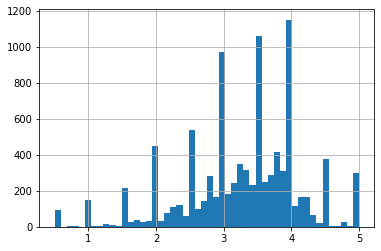

In [160]:
import matplotlib.pyplot as plt
rating['rating'].hist(bins=50)

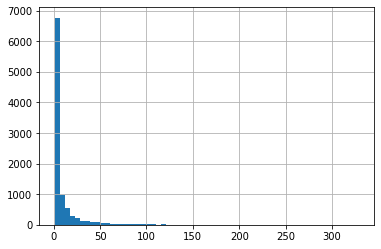

In [168]:
rating['number_of_ratings'].hist(bins=60)

see relationship between rating and number of ratings:

In [0]:
import seaborn as sns


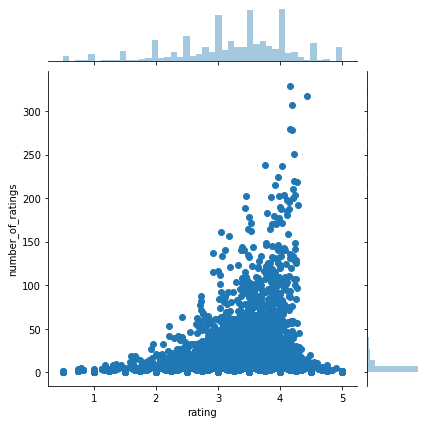

In [170]:
sns.jointplot(x='rating', y='number_of_ratings',data=rating)

The graph indicates that the more the ratings a movie gets the higher the average rating it gets.

we need to convert our dataset into a matrix with the movie titles as the columns, the user_id as the index and the ratings as the values. By doing this we shall get a dataframe with the columns as the movie titles and the rows as the user ids. Each column represents all the ratings of a movie by all users. The rating appear as NAN where a user didn't rate a certain movie. We shall use this matrix to compute the correlation between the ratings of a single movie and the rest of the movies in the matrix. 

In [174]:
movie_matrix=df.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.sample(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Next let’s look at the most rated movies and choose two of them to work with in this simple recommender system:


In [175]:
rating.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


assume a user watched 'the matrix 1999' & 'silence of the lambs', we can suggest him more movies using this watching history. first we need find correlation between these two movie's ratings and other movies of the dataset, to find similar movies.


The first step is to create a dataframe with the ratings of these movies from our movie_matrix.

In [0]:
matrix_user_rating=movie_matrix['Matrix, The (1999)']
stl_user_rating=movie_matrix['Silence of the Lambs, The (1991)']

We now have the dataframes showing the user_id and the rating they gave the two movies. Let's take a look at them below.

In [194]:
matrix_user_rating.sample(10)


userId
566    NaN
42     5.0
24     4.0
591    5.0
327    NaN
592    NaN
150    NaN
595    NaN
478    NaN
131    3.0
Name: Matrix, The (1999), dtype: float64

In [195]:
stl_user_rating.sample(10)

userId
220    NaN
447    4.0
330    5.0
535    NaN
345    NaN
438    NaN
460    NaN
605    NaN
13     NaN
475    NaN
Name: Silence of the Lambs, The (1991), dtype: float64

In order to compute the correlation between two dataframes we use pandas corwith functionality. Corrwith computes the pairwise correlation of rows or columns of two dataframe objects. Let's use this functionality to get the correlation between each movie's rating and the ratings of the 'silence of the lambs':

In [0]:
similar_to_stl=movie_matrix.corrwith(stl_user_rating)

In [206]:
similar_to_stl.sample(20)

title
Loved Ones, The (2009)                                            NaN
Night Guards (2016)                                               NaN
The Wailing (2016)                                                NaN
G-Force (2009)                                                    NaN
Closer to the Moon (2013)                                         NaN
Mouchette (1967)                                                  NaN
My Scientology Movie (2016)                                       NaN
Fur: An Imaginary Portrait of Diane Arbus (2006)                  NaN
Rio (2011)                                                   0.646230
G.B.F. (2013)                                                     NaN
Our Lips Are Sealed (2000)                                        NaN
Perfect Score, The (2004)                                   -0.970725
Prime Suspect 6: The Last Witness (2003)                          NaN
Legend of Sleepy Hollow, The (1980)                               NaN
Jeff Ross Roas

In [0]:
similar_to_mtrx=movie_matrix.corrwith(matrix_user_rating)

In [207]:
similar_to_mtrx.sample(20)

title
Manhattan Murder Mystery (1993)                            -0.489269
Good Burger (1997)                                               NaN
Warriors of Heaven and Earth (Tian di ying xiong) (2003)   -1.000000
Turtles Can Fly (Lakposhtha hâm parvaz mikonand) (2004)          NaN
Ides of March, The (2011)                                   0.176227
Besieged (a.k.a. L' Assedio) (1998)                              NaN
Stone Reader (2002)                                              NaN
Kuffs (1992)                                                     NaN
Collector, The (La collectionneuse) (1967)                       NaN
Kizumonogatari II: Passionate Blood (2016)                       NaN
Breakfast with Scot (2007)                                       NaN
Bad News Bears, The (1976)                                 -0.090154
South Park: Imaginationland (2008)                          0.108465
Destiny Turns on the Radio (1995)                                NaN
Collision Course (1989)     

The correlation is not realistic because we are only comparing avg ratings or number of ratings, which is not very realistic to guess the similarity between movies.


drop those null values and transform correlation results into dataframes to make the results look more appealing.:

In [212]:
corr_stl=pd.DataFrame(similar_to_stl,columns=['Correlation'])
corr_stl.dropna(inplace=True)
corr_stl.sample(20)

,Correlation
title,
Club Dread (2004),0.359313
Finding Forrester (2000),0.394307
Angus (1995),-0.154508
Kuffs (1992),1.000000
Jules and Jim (Jules et Jim) (1961),0.000000
Trainwreck (2015),0.336488
Toy Story 3 (2010),0.482473
Freeway (1996),0.818182
Thirteen Ghosts (a.k.a. Thir13en Ghosts) (2001),0.118958


In [214]:
corr_mtrx=pd.DataFrame(similar_to_mtrx,columns=['Correlation'])
corr_mtrx.dropna(inplace=True)
corr_mtrx.sample(10)

,Correlation
title,
Angels with Dirty Faces (1938),-1.000000
"Band's Visit, The (Bikur Ha-Tizmoret) (2007)",-0.866025
Noises Off... (1992),1.000000
Sliding Doors (1998),0.409935
"Bodyguard, The (1992)",0.232336
Real Genius (1985),-0.108700
"Minus Man, The (1999)",1.000000
Tadpole (2002),0.188982
Lord of the Flies (1990),0.366900


set a minimum value for number of ratings so no unrealistic values comes to stats:

find correlation with only those movies which has atleast 100 ratings:


In [228]:
corr_mtrx[rating['number_of_ratings']>100].sort_values(by='Correlation',ascending=False).head(10)

,Correlation
title,
"Matrix, The (1999)",1.000000
Die Hard (1988),0.544466
Inception (2010),0.514767
Braveheart (1995),0.496045
Aliens (1986),0.470865
"Lion King, The (1994)",0.444932
"Monsters, Inc. (2001)",0.441205
Batman Begins (2005),0.440338
Jurassic Park (1993),0.427936


In [229]:
corr_stl[rating['number_of_ratings']>100].sort_values(by='Correlation',ascending=False).head(10)

,Correlation
title,
"Silence of the Lambs, The (1991)",1.000000
Memento (2000),0.536660
Aliens (1986),0.492863
Shrek (2001),0.440900
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",0.437687
"Big Lebowski, The (1998)",0.431846
Groundhog Day (1993),0.430134
American History X (1998),0.420858
Minority Report (2002),0.416317


**summary: in the first row we have the movie itself, which is natural. we can recommend subsequent movies to the use as they have atleast 100 ratings and has greate correlation with previously watched movies by the use.**